# Homework 3.1 - Introduction to clustering with scikit-learn

### Introduction to the notebook

This first notebook will walk through the basics of using skikit-learn for building a classification model using k-means clustering. K means clustering is an unsupervised machine learning technique that groups data points based on their similarity or closeness of features. It works by finding the centre (mean) of each cluster and assigning data points to the nearest cluster. 

Thanks to the scikit-learn library, we can leverage ready-made functions that can accelerate the process of building a model. This notebook will explore this process using a sample dataset...

In [1]:
# Install scikit-learn
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     -------------------------------- ----- 51.2/60.4 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 809.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   -- ------------------------------------- 0.6/9.2 MB 11.8 MB/s eta 0:00:01
   ------- -------------------------------- 1.8/9.2 MB 18.7 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.2 MB 21.2 MB/s eta 0:00:01
   ------------------ --------------------- 4.2/9.2 MB 22.3 MB/s eta 0:00:01
   ---------------------- ----------------- 5.2/9.2 MB 22.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.9/9.2 MB 22.4 MB/s eta 0:00:01
   --------------------------------- ------ 7.7/9.2 MB 23.4 MB/s eta 0:00:01
   ------

In [2]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler # for standardising the data
from sklearn.datasets import load_wine # For loading the dataset
from sklearn.cluster import KMeans # For kmeans clustering
from sklearn.decomposition import PCA # For PCA decomposition - dimensionality reduction

In [3]:
# Let's load the data and take a peek...
raw_data = load_wine(as_frame=True)
wine_df = raw_data.frame

wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
targets = wine_df['target']
wine_df.drop('target', axis=1, inplace=True) # As clustering is unsupervised, we don't need the target column.
wine_df.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [ ]:
# Feel free to include your own code to explore the data with plots and summary statistics as done in week 2's homework...

In [5]:
scaler = StandardScaler() # Create an instance of the scaler, this will be used to scale the data before clustering because the features are on different scales so we need to standardise them
features_ = scaler.fit(wine_df) # Fit the scaler to the training data
features = features_.transform(wine_df) # Transform the features using the scaler
scaled_df = pd.DataFrame(features, columns=wine_df.columns) # Create a dataframe from the scaled features
X = scaled_df.values # Get the values from the dataframe

scaled_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore the FutureWarning that is thrown when plotting the elbow plot

wcss = [] # Create an empty list to store the within cluster sum of squares (WCSS) for each iteration of the kmeans algorithm. The WCSS is the sum of the squared distance between each point and the centroid in a cluster. The lower the WCSS the better the clustering.
for i in range(1, 16): # Iterate through the kmeans algorithm 15 times, each time increasing the number of clusters by 1.
    kmeans_model = KMeans(n_clusters=i, random_state=42) # Create an instance of the kmeans model, setting the number of clusters, the initialisation method and the random state.
    kmeans_model.fit(X) # Fit the model to the data.
    wcss.append(kmeans_model.inertia_)

wcss

[2314.0000000000005,
 1658.7588524290952,
 1277.928488844642,
 1175.4283331033473,
 1109.5127392938243,
 1046.0023332143637,
 981.5952326111658,
 935.2012114738545,
 889.8929111933174,
 845.8952366525514,
 825.856622696284,
 801.9948798306374,
 772.0168917857955,
 742.6749442199672,
 727.4495524972517]

### Determine the optimal number of clusters using the 'elbow' method

The elbow method is a heuristic used in determining the number of clusters in a specific dataset. The method consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use. Naturally, increasing the number of clusters will improve the fit of the model, since there are more clusters to use, but that at some point this is over-fitting, and the 'elbow' reflects this. 

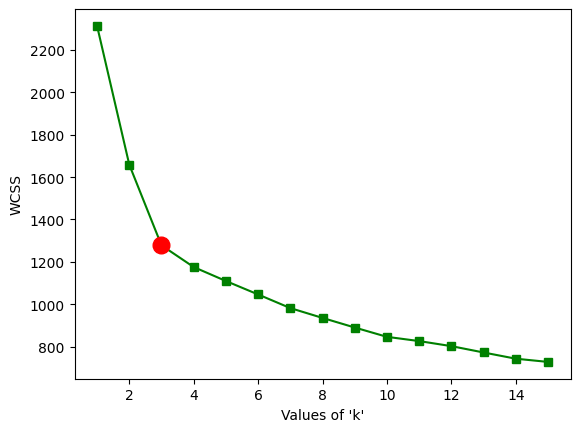

In [7]:
plt.plot([x for x in range(1, 16)], wcss, 'gs-') # Plot the elbow plot, the x axis is the number of clusters and the y axis is the WCSS.
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.plot([3], [wcss[2]], 'ro', ms=12, mfc='r') # Circle the elbow point on the plot, this is the optimal number of clusters.
plt.show() # Elbow method to determine the optimal number of clusters. The elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset. The optimal number of clusters is the value of k at the elbow i.e. the point after which the WCSS does not decrease significantly with every iteration.

In [8]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42) # Create an instance of the kmeans algorithm with 3 clusters because the elbow method suggests that 3 is the optimal number of clusters
kmeans.fit(X)
centres = kmeans.cluster_centers_ # Get the coordinates of the centroids for each cluster. As there are 15 features, there are 15 dimensions. We can't visualise 15 dimensions so we need to reduce the dimensions to 2 using PCA

centres

array([[-0.92607185, -0.39404154, -0.49451676,  0.17060184, -0.49171185,
        -0.07598265,  0.02081257, -0.03353357,  0.0582655 , -0.90191402,
         0.46180361,  0.27076419, -0.75384618],
       [ 0.16490746,  0.87154706,  0.18689833,  0.52436746, -0.07547277,
        -0.97933029, -1.21524764,  0.72606354, -0.77970639,  0.94153874,
        -1.16478865, -1.29241163, -0.40708796],
       [ 0.83523208, -0.30380968,  0.36470604, -0.61019129,  0.5775868 ,
         0.88523736,  0.97781956, -0.56208965,  0.58028658,  0.17106348,
         0.47398365,  0.77924711,  1.12518529]])

### Using organic features from the original dataset

Usually we would do some exploratory data analysis to determine which features we will use, but in this case we will use two randomly chosen features...

In [9]:
# Let's try using 2 random features from the original dataset to see if we can improve the clustering. In reality, we would use domain knowledge to select the features to use for clustering - we would do some exploratory data analysis to see which features are most correlated with the target variable and select those features for clustering.

X_ = scaled_df[['alcohol', 'flavanoids']].values # Get the features from the dataframe

# We need the index of the features we selected to get the coordinates of the centroids for each cluster. We can get the index of the features from the dataframe.
alcohol_index = 0
flavanoids_index = 6

alcohol_centroids = centres[:, alcohol_index] # Get the coordinates of the centroids for each cluster for the alcohol feature
flavanoids_centroids = centres[:, flavanoids_index] # Get the coordinates of the centroids for each cluster for the flavanoids feature

#### Assessing the model

K-means clustering does not use any labels or class information to assign the clusters. Therefore, the labels that k-means assigns to the clusters are arbitrary and may not match the true labels of the data points. Plotting the clusters next to the original data is a useful way to visualise the results of k-means clustering, especially if the data has two or three dimensions.

The silhouette score is a metric that evaluates how well each data point fits in its assigned cluster, and how well it is separated from other clusters. The silhouette score ranges from -1 to 1, where a higher value means a better clustering result. A silhouette score of 1 means that the data point is very similar to its own cluster, and very different from other clusters. A silhouette score of 0 means that the data point is close to the boundary between two clusters. A silhouette score of -1 means that the data point is more similar to another cluster than to its own cluster. In Python, we can use the `sklearn` library to perform k-means clustering and calculate the silhouette score. The `sklearn.metrics` module provides two functions: `silhouette_score` and `silhouette_samples`. The `silhouette_score` function returns the average silhouette score for the data set, given the cluster labels. The `silhouette_samples` function returns the silhouette score for each data point, which can be used to plot a silhouette diagram.

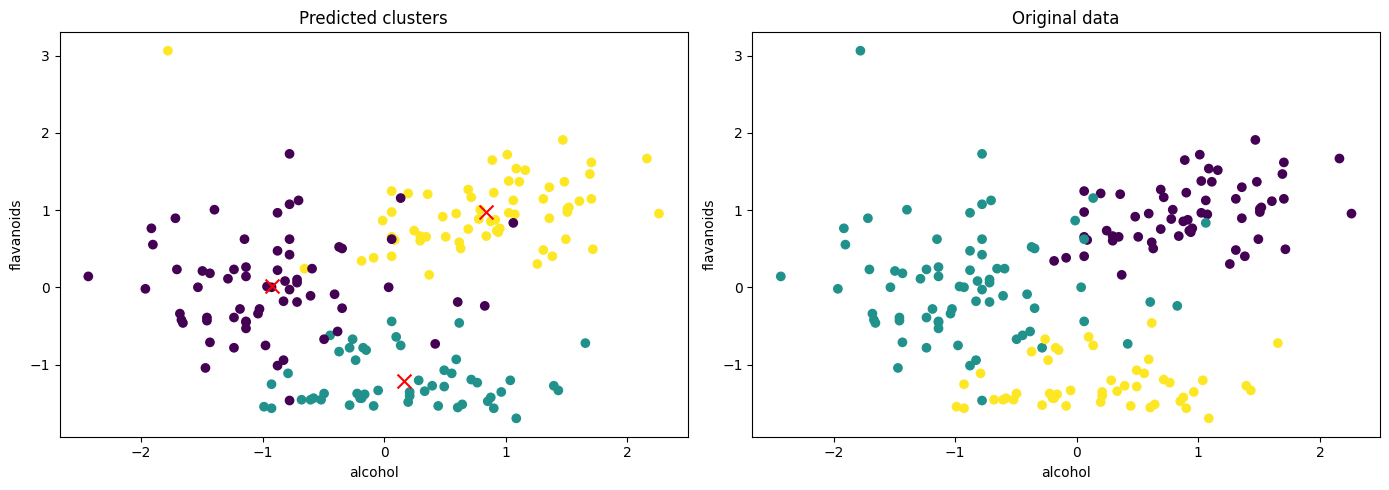

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) # Create a figure with two subplots.

ax1.scatter(X_[:,0], X_[:,1], c=kmeans.labels_) # Plot the clusters and the centroids
ax1.scatter(alcohol_centroids[:], flavanoids_centroids[:], marker='x', s=100,c='red')
ax1.set_xlabel('alcohol')
ax1.set_ylabel('flavanoids')
ax1.set_title('Predicted clusters')
ax2.scatter(X_[:,0], X_[:,1], c=targets) # Plot the original data with the target variable.
ax2.set_xlabel('alcohol')
ax2.set_ylabel('flavanoids')
ax2.set_title('Original data')
plt.tight_layout()
plt.show()

In [11]:
# We can use the silhouette score to evaluate the quality of the clusters. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1. A score of 1 indicates that the object is far away from the neighbouring clusters. A score of 0 indicates that the object is on or very close to the decision boundary between two neighbouring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. The higher the silhouette score the better the clustering.
from sklearn.metrics import silhouette_score

print(f'Silhouette score: {silhouette_score(X_, kmeans.labels_)}') # Get the silhouette score for the clusters

Silhouette score: 0.43299299791675816


### Principal component analysis (optional)

As our chosen dataset has a large number of features (dimensions), we could choose to break it down using principal component analysis. Principal component analysis, or PCA, is a method that reduces the dimensionality of a data set by transforming a large set of variables into a smaller one that still contains most of the information in the large set. This makes it easier to explore and visualise the data, as well as to perform machine learning tasks on it.

The basic idea of PCA is to find the directions in which the data varies the most, and project the data onto those directions. These directions are called principal components, and they are orthogonal to each other. The first principal component captures the most variance in the data, the second one captures the second most, and so on. By choosing a subset of principal components, we can reduce the number of dimensions while preserving as much information as possible.

_Further reading on this can be found in the `README.md` file. Please note this is an extension task._

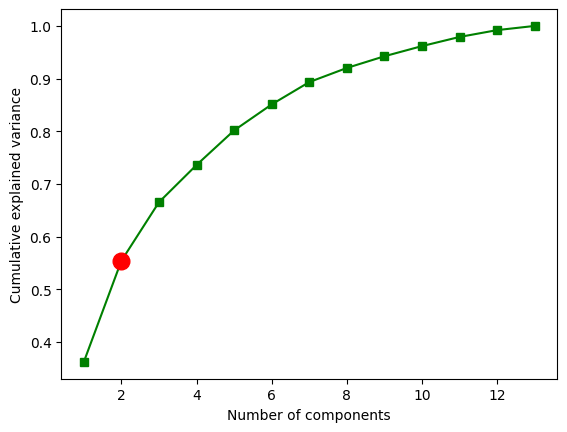

In [12]:
# We can find the optimal number of components for PCA. We can do this by plotting the cumulative explained variance ratio against the number of components. We aim for the cumulative explained variance ratio to be as close to 1 as possible. The cumulative explained variance ratio is the proportion of the variance in the original data that is explained by the components. The more components we use the more variance we can explain but we want to use as few components as possible to avoid overfitting. We can see from the plot that 2 components explains around 60% of the variance in the original data so we will use 2 components for PCA - this means we can visualise the clusters in 2 dimensions.
pca = PCA() # Create an instance of the PCA model
pca.fit(X) # Fit the model to the data
cumulative_explained_variance = [] # Create an empty list to store the cumulative explained variance for each component
for i in range(1, 14): # Iterate through the number of components
    cumulative_explained_variance.append(sum(pca.explained_variance_ratio_[:i])) # Append the cumulative explained variance for each component to the list
plt.plot([x for x in range(1, 14)], cumulative_explained_variance, 'gs-') # Plot the cumulative explained variance against the number of components
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.plot([2], [cumulative_explained_variance[1]], 'ro', ms=12, mfc='r') # We will use 2 components for PCA as, although it doesn't have the highest cumulative explained variance, it means we can visualise the clusters in 2 dimensions.
plt.show()

In [13]:
pca = PCA(n_components=2) # Create an instance of the PCA model with 2 components
reduced_X = pd.DataFrame(data=pca.fit_transform(X.copy()), columns=['PCA-feature1', 'PCA-feature2']) # Create a dataframe from the reduced features.
centres_pca = pca.transform(centres) # Transform the coordinates of the centroids for each cluster using the PCA algorithm.

centres_pca

array([[-0.03695661,  1.77223945],
       [-2.72003575, -1.12565126],
       [ 2.2761936 , -0.93205403]])

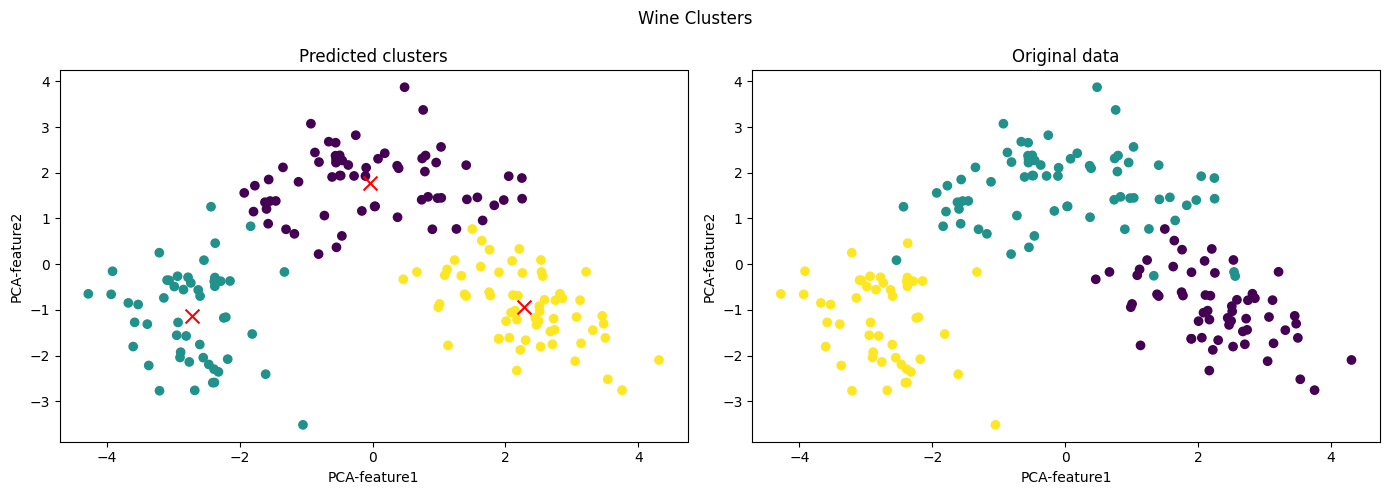

In [14]:
# Let's plot the clusters next to the original data in two different subplots. As clustering is unsupervised, we don't have a target variable to compare the clusters to. However, we can compare the clusters to the original data to see if the clusters make sense.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) # Create a figure with two subplots.
fig.suptitle('Wine Clusters')
ax1.scatter(reduced_X['PCA-feature1'], reduced_X['PCA-feature2'], c=kmeans.labels_) # Plot the clusters and the centroids after reducing the dimensionality of the data to 2 dimensions using the PCA algorithm
ax1.scatter(centres_pca[:,0], centres_pca[:,1], marker='x', s=100,c='red')
ax1.set_xlabel('PCA-feature1')
ax1.set_ylabel('PCA-feature2')
ax1.set_title('Predicted clusters')
ax2.scatter(reduced_X['PCA-feature1'], reduced_X['PCA-feature2'], c=targets) # Plot the original data with the target variable.
ax2.set_xlabel('PCA-feature1')
ax2.set_ylabel('PCA-feature2')
ax2.set_title('Original data')
plt.tight_layout()
plt.show()

In [15]:
print(f'Silhouette score: {silhouette_score(reduced_X, kmeans.labels_)}') # Print the silhouette score for the clusters.

Silhouette score: 0.5583363740907524
